In [1]:
import os
import pandas as pd

# Initialize an empty list to store dataframes
dfs = []

# Traverse through the directory and subdirectories
path = '/home/box/coding/CTIR/Step_2/Reference_frames/element_coordinates.csv'
# Read the CSV file into a dataframe
df = pd.read_csv(path)  # Skip the first two rows

df = df.round(2)
df

,file,lever_tip_x,lever_tip_y,upper_lever_tip_x,upper_lever_tip_y,stick_head_x,stick_head_y,ball_x,ball_y,sliding_door_x,sliding_door_y,middle_front_x,middle_front_y,middle_back_x,middle_back_y,left_front_x,left_front_y
0,E1_front.png,525.36,446.67,506.80,109.76,261.87,474.28,688.95,439.52,675.83,402.94,308.33,547.63,317.01,402.21,844.89,522.60
1,E1_side.png,808.65,373.74,513.50,66.99,734.33,463.10,759.18,350.62,638.41,350.62,891.28,486.68,256.59,482.78,891.41,380.02
2,E1_top.png,352.30,162.13,348.21,302.43,501.62,201.38,253.07,194.87,254.25,274.80,471.89,122.95,471.34,469.96,182.05,118.33
3,E2_front.png,594.07,446.16,583.69,119.46,329.51,463.98,743.19,446.19,727.62,416.66,366.38,536.87,356.72,401.98,889.03,531.88
4,E2_side.png,790.17,375.81,491.29,94.23,730.67,454.72,743.29,360.61,641.30,365.87,879.53,480.34,246.75,492.33,868.64,394.87
5,E2_top.png,342.84,185.17,326.91,334.09,493.99,217.51,249.76,216.82,252.88,285.31,471.87,144.01,472.18,487.91,182.44,140.09


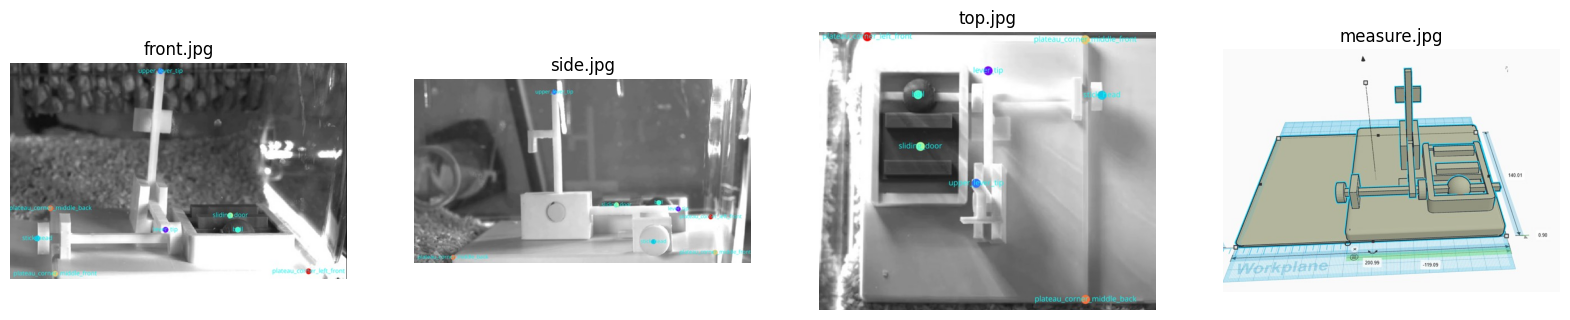

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define the path to the folder containing images
folder_path = '/home/box/coding/CTIR/Step_2/example'

# List of image filenames
image_filenames = ['front.jpg', 'side.jpg', 'top.jpg', 'measure.jpg']

# Load images
images = [mpimg.imread(os.path.join(folder_path, filename)) for filename in image_filenames]

# Plot images side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, img, filename in zip(axes, images, image_filenames):
    ax.imshow(img)
    ax.axis('off')  # Hide the axis
    ax.set_title(filename)

plt.show()


In [4]:
lock_box_parts = {
    "middle_front": (0, 0, 0),
    "lever_tip": (49, 24, 15),
    "upper_lever_tip": (49, 87, 82),
    "stick_head": (-9, 35, 9),
    "ball": (86, 34, 15),
    "sliding_door": (86, 67, 10),
    "middle_back": (0, 140, 0),
    "left_front": (120, 0, 0)
}

In [ ]:
#front y => z, side x => y, y => z


In [25]:
import numpy as np
import cv2

# 3D coordinates of the lockbox parts
lock_box_parts = {
    "middle_front": (0, 0, 0),
    "lever_tip": (49, 24, 15),
    "upper_lever_tip": (49, 87, 82),
    "stick_head": (-9, 35, 9),
    "ball": (86, 34, 15),
    "sliding_door": (86, 67, 10),
    "middle_back": (0, 140, 0),
    "left_front": (120, 0, 0)
}

# Convert dictionary to numpy array
points_3d = np.array(list(lock_box_parts.values()), dtype='float32')

# Corresponding 2D points from one of the images
points_2d = np.array([
    [308.33, 547.63],
    [525.36, 446.67],
    [506.80, 109.76],
    [261.87, 474.28],
    [688.95, 439.52],
    [675.83, 402.94],
    [317.01, 402.21],
    [844.89, 522.60]
], dtype='float32')

# Number of points
num_points = points_3d.shape[0]

# Construct the matrix A
A = []
for i in range(num_points):
    X, Y, Z = points_3d[i]
    u, v = points_2d[i]
    A.append([-X, -Y, -Z, -1, 0, 0, 0, 0, u*X, u*Y, u*Z, u])
    A.append([0, 0, 0, 0, -X, -Y, -Z, -1, v*X, v*Y, v*Z, v])

A = np.array(A)

# Perform SVD
U, S, Vt = np.linalg.svd(A)
P = Vt[-1].reshape(3, 4)

# Decompose P to obtain K, R, t
K, R, t = cv2.decomposeProjectionMatrix(P)[:3]
K /= K[2, 2]  # Normalize K to make K[2, 2] = 1

# Correct the sign and orientation if needed
if np.linalg.det(R) < 0:
    R = -R
    t = -t

print("Intrinsic matrix K:\n", K)
print("Rotation matrix R:\n", R)
print("Translation vector t:\n", t)

# Compute the reprojection error
points_2d_reproj = P @ np.hstack((points_3d, np.ones((num_points, 1)))).T
points_2d_reproj /= points_2d_reproj[2]  # Divide by the last row to normalize
points_2d_reproj = points_2d_reproj[:2].T

reprojection_error = np.mean(np.linalg.norm(points_2d - points_2d_reproj, axis=1))
print("Reprojection Error: ", reprojection_error)


Intrinsic matrix K:
 [[ 2.90185725e+03 -1.83365272e+02  6.43235679e+02]
 [ 0.00000000e+00  2.12196887e+03  2.03411475e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation matrix R:
 [[ 0.99419313 -0.10260145 -0.03188481]
 [-0.10095005 -0.79045443 -0.60411469]
 [ 0.03678089  0.60382545 -0.79622199]]
Translation vector t:
 [[-0.04214033]
 [ 0.95331192]
 [-0.29903006]
 [-0.00126273]]
Reprojection Error:  5.07512797767207


* Focal Lengths:
f_x = 2901.85725
f_y = 2121.96887

* Principal Point:
c_x = 643.235679
c_y = 2034.11475

* Skew:
s = -183.365272